## GOAL:

Propertycrime=α+Population+Population2+Murder+Robbery

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn import model_selection
import scipy.stats
%matplotlib inline

In [260]:
crime = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
                 )

## Clean the data

In [261]:
#cleaning, removing header rows
crime.columns = crime.iloc[3]
crime.droprow = crime.drop(crime.index[0:4], inplace=True)

#rename columns
crime.columns = ['city','population','violent_crime','murder','rape_revised',
                 'rape_legacy','robbery','agg_assault','property_crime','burglary','larceny_theft',
                 'motor_theft','arson3']
#remove na from pop
crime.dropna(subset = ['population'], inplace=True)
#drop rape (revised def 1)
crime.drop(['rape_revised'],axis=1,inplace=True)

# Change the Arson null values to 0. 
crime['arson3'].fillna(0, inplace=True)

In [262]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 4 to 351
Data columns (total 12 columns):
city              348 non-null object
population        348 non-null object
violent_crime     348 non-null object
murder            348 non-null object
rape_legacy       348 non-null object
robbery           348 non-null object
agg_assault       348 non-null object
property_crime    348 non-null object
burglary          348 non-null object
larceny_theft     348 non-null object
motor_theft       348 non-null object
arson3            348 non-null object
dtypes: object(12)
memory usage: 35.3+ KB


In [263]:
# remove and conver to float
crime = crime.replace(',', '', regex=True)
crime.iloc[:, 1:] = crime.iloc[:, 1:].apply(lambda x: pd.to_numeric(x))
crime = crime.reset_index(drop=True)

#giving murder and robbery indicators and creating pop ^2
crime['robbery_ind'] = crime.robbery.where(crime.robbery==0, 1)
crime['murder_ind'] = crime.murder.where(crime.murder==0,1)
crime['pop_sq'] = crime['population']**2

In [264]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 15 columns):
city              348 non-null object
population        348 non-null object
violent_crime     348 non-null object
murder            348 non-null object
rape_legacy       348 non-null object
robbery           348 non-null object
agg_assault       348 non-null object
property_crime    348 non-null object
burglary          348 non-null object
larceny_theft     348 non-null object
motor_theft       348 non-null object
arson3            348 non-null object
robbery_ind       348 non-null object
murder_ind        348 non-null object
pop_sq            348 non-null object
dtypes: object(15)
memory usage: 40.9+ KB


## Version 1

**Propertycrime=α+Population+Population2+Murder+Robbery**

In [265]:
#now keeping only desired columns to answer original 
crime_reg_1 = crime.loc[:, ['property_crime','population', 'pop_sq', 'murder_ind', 'robbery_ind']]

#reset index
crime_reg_1 = crime_reg_1.reset_index(drop=True)

In [266]:
crime_reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 5 columns):
property_crime    348 non-null object
population        348 non-null object
pop_sq            348 non-null object
murder_ind        348 non-null object
robbery_ind       348 non-null object
dtypes: object(5)
memory usage: 13.7+ KB


In [267]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_1[['population', 'pop_sq', 'murder_ind', 'robbery_ind']]
Y = crime_reg_1['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))


Coefficients: 
 [  3.46570268e-02  -2.11108019e-09   1.51866535e+01  -9.62774363e+01]

Intercept: 
 -109.575335623

R-squared:
0.996124710499


R^2 is very high. Possible overfitting. Let's split into test and train to see what the R^2 value is for test when we fit the train.

In [268]:
data = crime_reg_1[['population','pop_sq','murder_ind','robbery_ind']]
target = crime_reg_1['property_crime']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above. cocneptually play different role
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  #train_test_split makes a random choice

# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: {}',format(regr.score(data_test,target_test)))


Training Coefficients: 
 [  3.72064151e-02  -2.41386225e-09  -2.85854507e+01  -1.19355610e+02]

Training Intercept: 
 -103.825831696

Training R-squared:
The R^2 value for train set: {} 0.996831085676462
The R^2 value for test set: {} 0.570867910846872


Okay, something is not right. There is overfitting when making predictions.

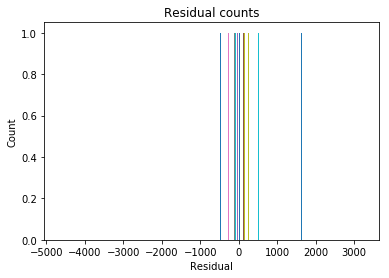

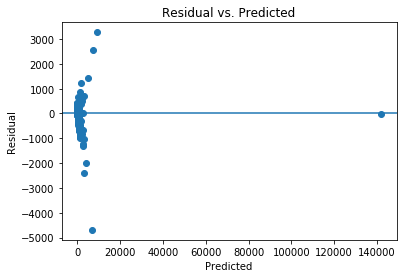

In [269]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_1['property_crime']

# Calculate residuals
residual = actual - predicted

# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

From prev assignment, we know the outlier is NYC. Let's look at the left part of this.

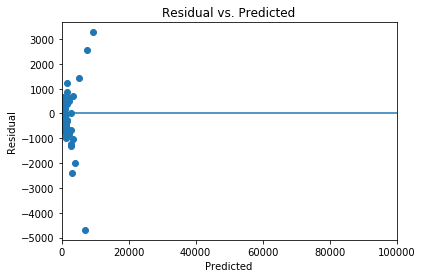

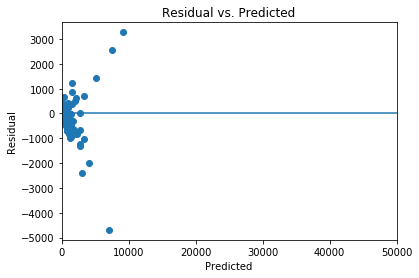

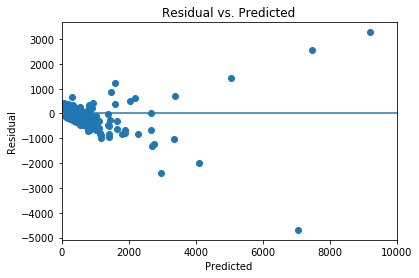

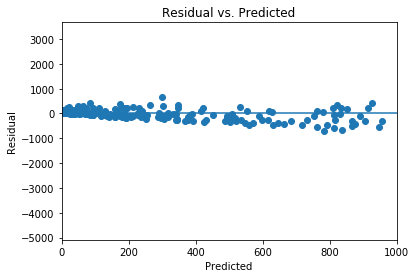

In [276]:
xlim = [(0,100000), (0,50000), (0,10000), (0,1000)]

for bounds in xlim:
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.xlim(bounds)
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()

As the predicted values get smaller, so doe the residual error.

## Feature Engineering.

In [284]:
crime_2 = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
                 )

In [285]:
# using original data, i will add new indicators and winzorize my continuous variables.

In [286]:
#cleaning, removing header rows
crime_2.columns = crime_2.iloc[3]
crime_2.droprow = crime_2.drop(crime_2.index[0:4], inplace=True)

#rename columns
crime_2.columns = ['city','population','violent_crime','murder','rape_revised',
                 'rape_legacy','robbery','agg_assault','property_crime','burglary','larceny_theft',
                 'motor_theft','arson3']
#remove na from pop
crime_2.dropna(subset = ['population'], inplace=True)
#drop rape (revised def 1)
crime_2.drop(['rape_revised'],axis=1,inplace=True)

# Change the Arson null values to 0. 
crime_2['arson3'].fillna(0, inplace=True)

In [294]:
#remove , and conver to float (for desired columns)
crime_2 = crime_2.replace(',','',regex=True)
crime_2.iloc[:,1:] = crime_2.iloc[:,1:].apply(lambda x: pd.to_numeric(x))
crime_2 = crime_2.reset_index(drop=True)

In [297]:

#creating indicators
crime_2['robbery_ind'] = crime_2.robbery.where(crime_2.robbery ==0,1)
crime_2['murder_ind'] = crime_2.murder.where(crime_2.murder ==0,1)
crime_2['rape_ind'] = crime_2.rape_legacy.where(crime_2.rape_legacy ==0,1)
crime_2['assault_ind'] = crime_2.agg_assault.where(crime_2.agg_assault ==0,1)
crime_2['arson_ind'] = crime_2.arson3.where(crime_2.arson3 ==0,1)

In [298]:
#now keeping only desired columns to answer original 
crime_reg_2 = crime_2.loc[:, ['property_crime','population', 'murder_ind', 'robbery_ind','rape_ind','assault_ind','arson_ind']]

#reset index
crime_reg_2 = crime_reg_2.reset_index(drop=True)

In [299]:

crime_reg_2.describe()

,property_crime,population,murder_ind,robbery_ind,rape_ind,assault_ind,arson_ind
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,792.606,40037.632,0.141,0.601,0.414,0.810,0.155
std,7659.725,450037.368,0.348,0.490,0.493,0.393,0.363
min,0.000,526.000,0.000,0.000,0.000,0.000,0.000
25%,40.500,3003.000,0.000,0.000,0.000,1.000,0.000
50%,112.500,7233.500,0.000,1.000,0.000,1.000,0.000
75%,341.000,18427.500,0.000,1.000,1.000,1.000,0.000
max,141971.000,8396126.000,1.000,1.000,1.000,1.000,1.000


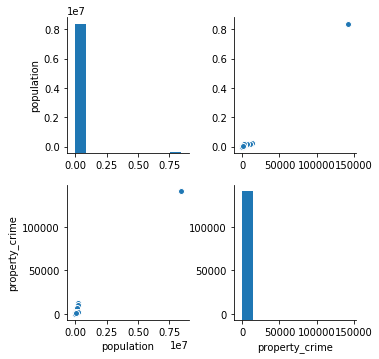

In [300]:
#pairplot, exluding the binary indicators
sns.pairplot(crime_reg_2[['population','property_crime']])

In [301]:
#looking at stats and pairpolots, there are clearly extreme data points in pop and property crime
#winzorize my data, as while the values in the variables could be extreme, they could also be likely given the range in cities
#nd pops
for column in crime_reg_2.loc[:,'property_crime':'murder_ind']:
    crime_reg_2[column] = scipy.stats.mstats.winsorize(crime_reg_2[column],limits=[0.05,0.05])

In [302]:
#add pop sq now
crime_reg_2['pop_sq'] =crime_reg_2['population'] **2

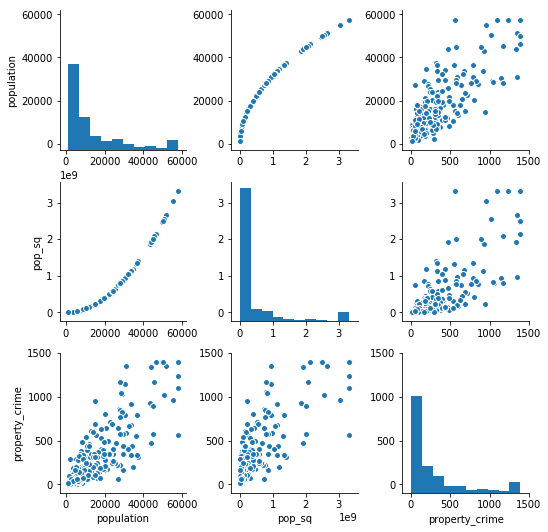

In [303]:
sns.pairplot(crime_reg_2[['population','pop_sq','property_crime']])

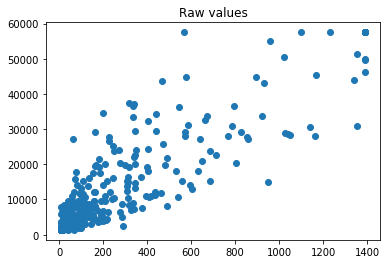

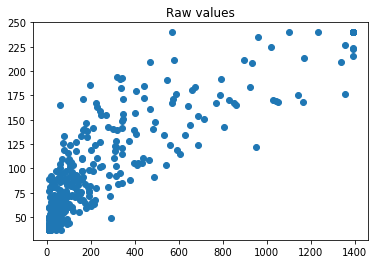

In [304]:
#is is getting easier to examine the data points now. 
#Pop and pop sq do have a positive relationship with property_crime but they are not fully linnear. Let sdo some transformations

plt.scatter(crime_reg_2['property_crime'], crime_reg_2['population'])
plt.title('Raw values')
plt.show()

crime_reg_2['sqrt_pop'] = np.sqrt(crime_reg_2['population'])

plt.scatter(crime_reg_2['property_crime'], crime_reg_2['sqrt_pop'])
plt.title('Raw values')
plt.show()

In [305]:
#OK lets check the model again

In [306]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_2[['population','pop_sq','murder_ind','robbery_ind','rape_ind','assault_ind','arson_ind']]
Y = crime_reg_2['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))


Coefficients: 
 [  8.72896312e-03   1.79477127e-07   6.67299135e+01   6.97067843e+01
   9.93157310e+01   9.56760068e+00   4.91374374e+01]

Intercept: 
 -20.9628372508

R-squared:
0.837852579411


In [307]:
data = X
target = Y

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above. cocneptually play different role
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  #train_test_split makes a random choice
# # Fit our model to the data.
regr.fit(data_train, target_train)

# classify and store the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: {}',format(regr.score(data_test,target_test)))


Training Coefficients: 
 [  8.24205558e-03   1.82924537e-07   6.51155159e+01   5.28461493e+01
   1.15654501e+02   1.57527274e+01   7.58117305e+01]

Training Intercept: 
 -16.2777230992

Training R-squared:
The R^2 value for train set: {} 0.8543481781936173
The R^2 value for test set: {} 0.7994218950093819


R^2 is better than before.

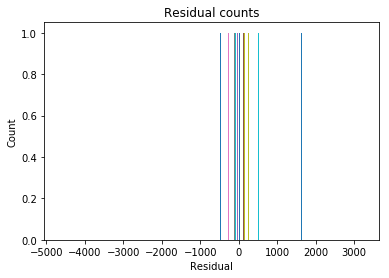

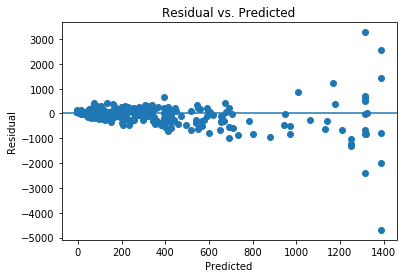

In [308]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_2['property_crime']

# Calculate residuals.
residuals = actual - predicted

# Histogram of residuals
plt.hist(residual, bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [310]:

#Going to try one more thing, with a power transfpormation of property_crime

power = 0.25
Y_mod = Y**power

regr.fit(X, Y_mod)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y_mod))


Coefficients: 
 [  7.16193734e-05  -4.68621156e-10   1.13485959e-01   5.65750527e-01
   4.63688994e-01   3.42586356e-01   1.76884771e-01]

Intercept: 
 1.84763269058

R-squared:
0.860645908283


In [311]:
data = X
target = Y_mod

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above. cocneptually play different role
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  #train_test_split makes a random choice
# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: {}',format(regr.score(data_test,target_test)))


Training Coefficients: 
 [  7.04264953e-05  -4.60112446e-10   9.66749891e-02   5.80055556e-01
   4.77041773e-01   3.42335421e-01   2.09985245e-01]

Training Intercept: 
 1.86983309352

Training R-squared:
The R^2 value for train set: {} 0.865740571046596
The R^2 value for test set: {} 0.8466117087950124


The scores are much closer now between train and test groups.